In [17]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras

In [18]:
import bayesflow as bf
from dmc import DMC

## Create Simulator

In [19]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500,
    contamination_probability=.05
)

In [20]:
sims = simulator.sample(10)
for k, v in sims.items():
    print(f"Shape of {k}: {v.shape}")

Shape of A: (10, 1)
Shape of tau: (10, 1)
Shape of mu_c: (10, 1)
Shape of t0: (10, 1)
Shape of b: (10, 1)
Shape of rt: (10, 200, 1)
Shape of accuracy: (10, 200, 1)
Shape of conditions: (10, 200, 1)
Shape of num_obs: (10, 1)


## Create Adapter

In [21]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "t0", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)

In [22]:
for k, v in adapter(sims).items():
    print(f"Shape of {k}: {v.shape}")

Shape of inference_variables: (10, 5)
Shape of summary_variables: (10, 200, 3)
Shape of inference_conditions: (10, 1)


## Create Networks and Workflow

In [23]:
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.1)))

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.1)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=1e-4,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../checkpoints',
    checkpoint_name= "simons_crazy_net_batchsize32",
    inference_variables=["A", "tau", "mu_c", "t0", "b"]
)

## Generate Data and Train Offline

In [10]:
file_path = '../data/data_offline_training/data_offline_training.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)



In [24]:
    
val_file_path = '../data/data_offline_training/data_offline_validation.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)

In [25]:
%%time
history = workflow.fit_offline(train_data, epochs=100, batch_size=32, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - loss: 4.6173 - loss/inference_loss: 4.6173 - val_loss: 6.1897 - val_loss/inference_loss: 6.1897
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - loss: 2.8274 - loss/inference_loss: 2.8274 - val_loss: 4.6946 - val_loss/inference_loss: 4.6946
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - loss: 1.9555 - loss/inference_loss: 1.9555 - val_loss: 3.4100 - val_loss/inference_loss: 3.4100
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 171s 110ms/step - loss: 1.7206 - loss/inference_loss: 1.7206 - val_loss: 3.6986 - val_loss/inference_loss: 3.6986
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 172s 110ms/step - loss: 1.4807 - loss/inference_loss: 1.4807 - val_loss: 2.8044 - val_loss/inference_loss: 2.8044
Epoch 6/100
 956/1563 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 1.3191 - loss/inference_loss: 1.3191

KeyboardInterrupt: 

## In Silico Validation
figs = workflow.plot_default_diagnostics(test_data=val_data)

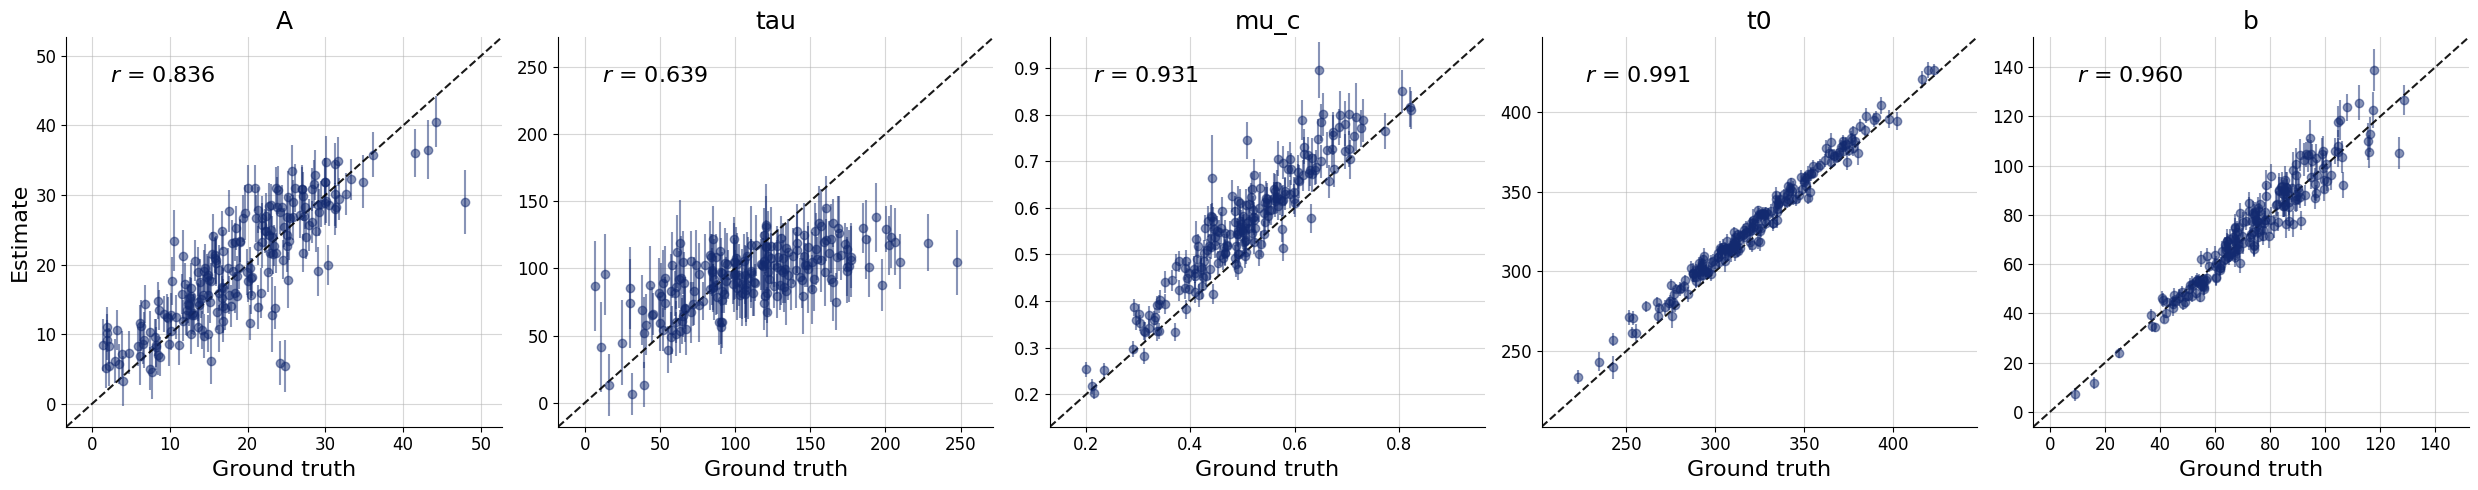

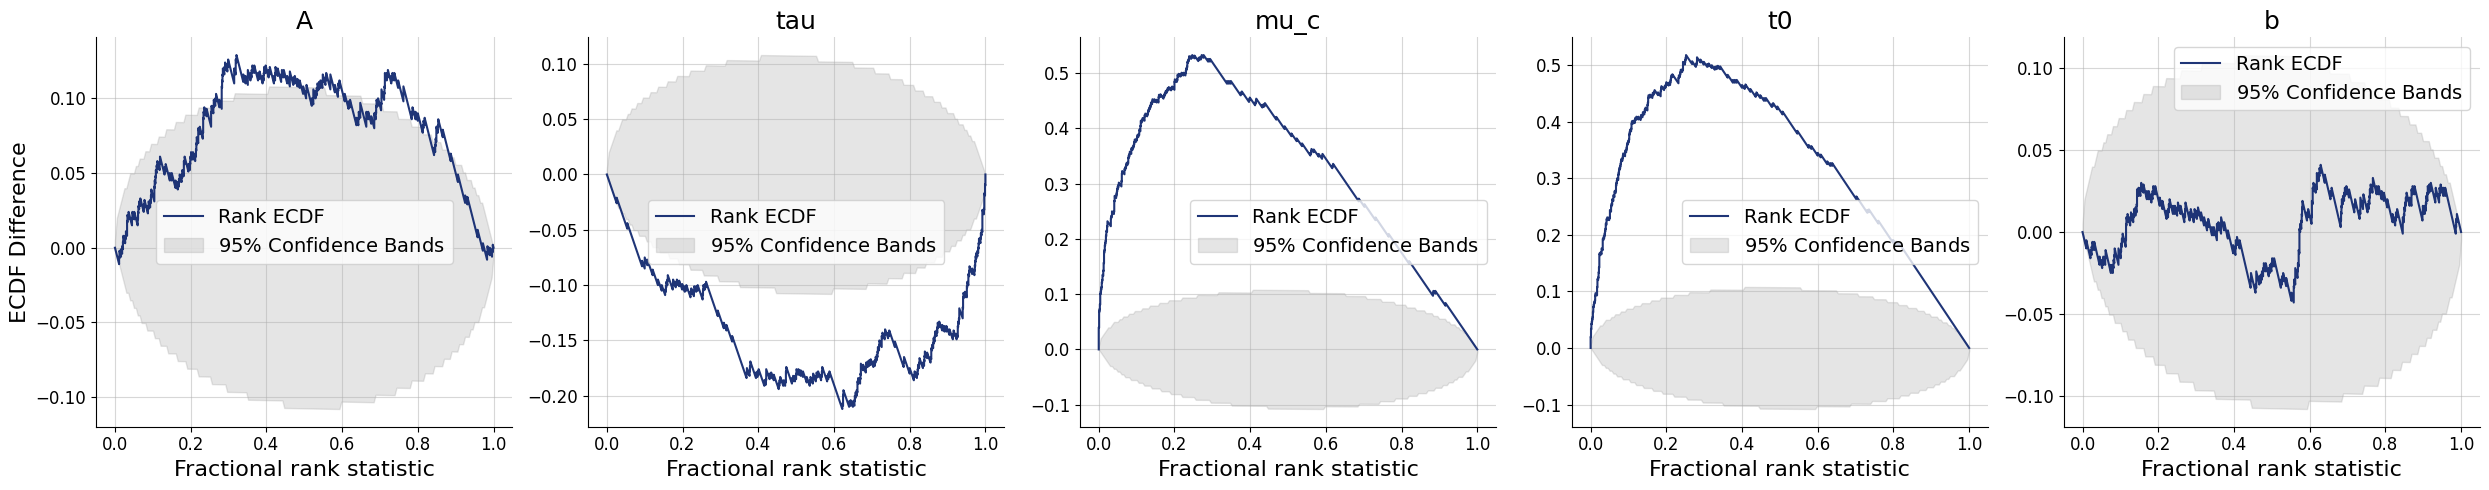

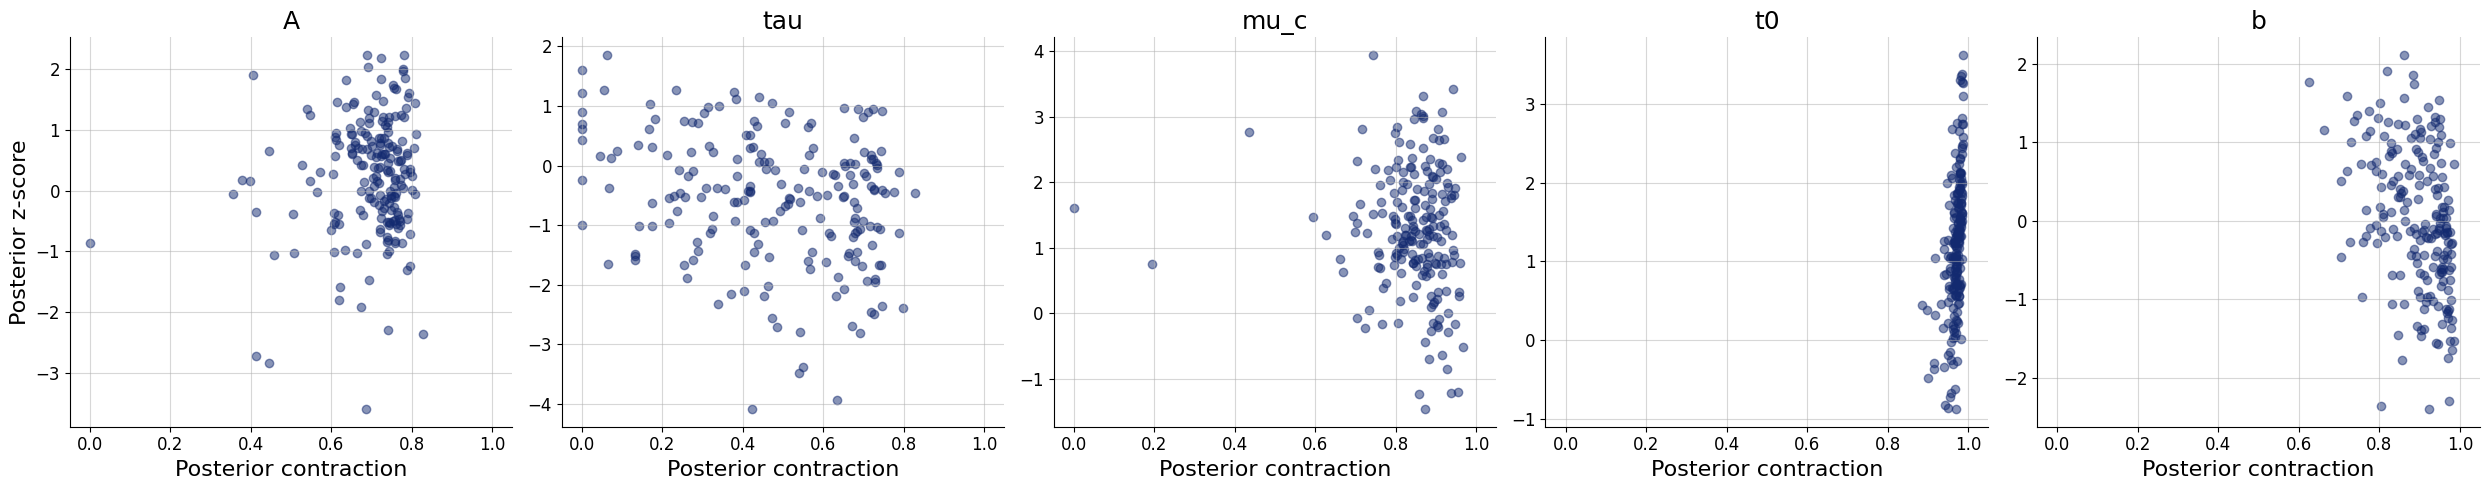

In [27]:
approximator = keras.saving.load_model("../checkpoints/simons_crazy_net.keras")

figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))

In [28]:
table = workflow.compute_default_diagnostics(test_data=val_data)
table

,A,tau,mu_c,t0,b
NRMSE,0.148996,0.213710,0.143126,0.052944,0.076646
Posterior Contraction,0.720386,0.491547,0.861639,0.972243,0.914590
Calibration Error,0.008816,0.042237,0.247763,0.210263,0.022632


In [ ]:
# table = workflow.compute_custom_diagnostics(test_data=val_data)

TypeError: BasicWorkflow.compute_custom_diagnostics() missing 1 required positional argument: 'metrics'

## Custom Stuff

In [28]:
samples = approximator.sample(conditions=val_data, num_samples=1000)

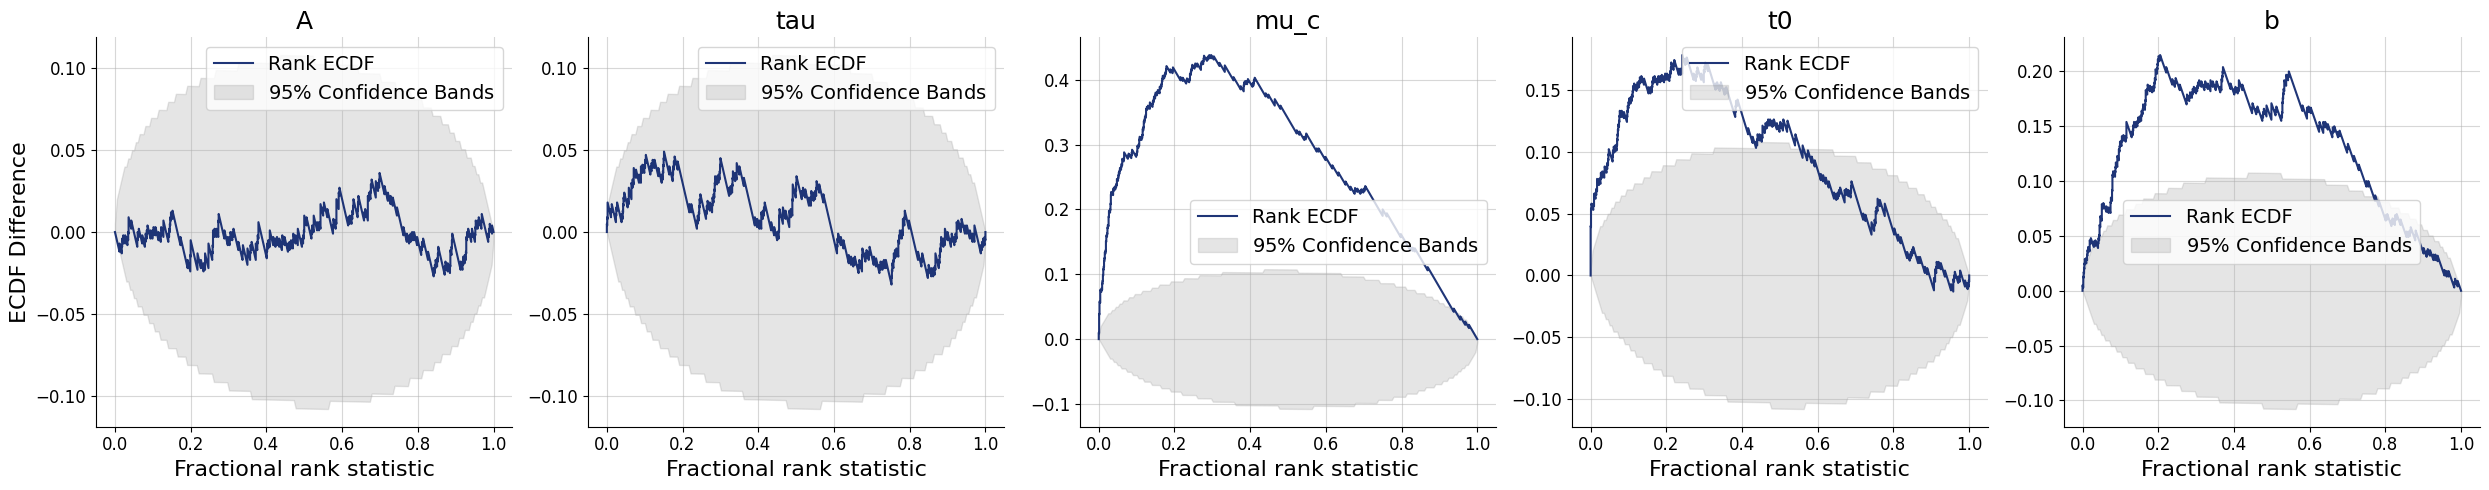

In [29]:
sbc = bf.diagnostics.plots.calibration_ecdf(samples, val_data, variable_keys=["A", "tau", "mu_c", "t0", "b"], difference=True)

## Real Data Inference

In [ ]:
#TODO



## Posterior Predictive Checks

In [ ]:
#TODO